In [1]:
###########################################################
# Imports
###########################################################

import sys  
sys.path.insert(1, '/Users/isobel/Desktop/DUNE/2024/Hierarchy')

import uproot
import numpy as np
import glob

import torch
from torch.utils.data import Dataset, DataLoader

import itertools

import Models_torch
import HierarchyDatasets
import TrainingMetrics

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
# trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_*.npz')
# trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_track_noPrimaries.npz')
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_*_track_noPrimaries_wCutInfo_extraVar_NEW.npz')

print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_1_track_noPrimaries_wCutInfo_extraVar_NEW.npz', '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_track_noPrimaries_wCutInfo_extraVar_NEW.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

N_EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.5
USE_PID = False

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 90))
variables_test = np.empty((0, 90))

# Truth
y_train = np.empty((0, 4))
y_test = np.empty((0, 4))
trueParentChildLink_train = np.empty((0), dtype='int')
trueParentChildLink_test = np.empty((0), dtype='int')
trueChildVisibleGeneration_train = np.empty((0), dtype='int')
trueChildVisibleGeneration_test = np.empty((0), dtype='int')
trainingCutSep_train = np.empty((0), dtype='float')
trainingCutSep_test = np.empty((0), dtype='float')
trainingCutDoesConnect_train = np.empty((0), dtype='float')
trainingCutDoesConnect_test = np.empty((0), dtype='float')
trainingCutL_train = np.empty((0), dtype='float')
trainingCutL_test = np.empty((0), dtype='float')
trainingCutT_train = np.empty((0), dtype='float')
trainingCutT_test = np.empty((0), dtype='float')

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)
    trueParentChildLink_train = np.concatenate((trueParentChildLink_train, data['trueParentChildLink_train']), axis=0)
    trueParentChildLink_test = np.concatenate((trueParentChildLink_test, data['trueParentChildLink_test']), axis=0)
    trueChildVisibleGeneration_train = np.concatenate((trueChildVisibleGeneration_train, data['trueChildVisibleGeneration_train']), axis=0)
    trueChildVisibleGeneration_test = np.concatenate((trueChildVisibleGeneration_test, data['trueChildVisibleGeneration_test']), axis=0)
    trainingCutSep_train = np.concatenate((trainingCutSep_train, data['trainingCutSep_train']), axis=0)
    trainingCutSep_test = np.concatenate((trainingCutSep_test, data['trainingCutSep_test']), axis=0)
    trainingCutDoesConnect_train = np.concatenate((trainingCutDoesConnect_train, data['trainingCutDoesConnect_train']), axis=0)
    trainingCutDoesConnect_test = np.concatenate((trainingCutDoesConnect_test, data['trainingCutDoesConnect_test']), axis=0)
    trainingCutL_train = np.concatenate((trainingCutL_train, data['trainingCutL_train']), axis=0)
    trainingCutL_test = np.concatenate((trainingCutL_test, data['trainingCutL_test']), axis=0)
    trainingCutT_train = np.concatenate((trainingCutT_train, data['trainingCutT_train']), axis=0)
    trainingCutT_test = np.concatenate((trainingCutT_test, data['trainingCutT_test']), axis=0)

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_1_track_noPrimaries_wCutInfo_extraVar_NEW.npz , This may take a while...
Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0_track_noPrimaries_wCutInfo_extraVar_NEW.npz , This may take a while...


In [5]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trueParentChildLink_train.shape:', trueParentChildLink_train.shape)
print('trueParentChildLink_test.shape:', trueParentChildLink_test.shape)
print('trueChildVisibleGeneration_train.shape:', trueChildVisibleGeneration_train.shape)
print('trueChildVisibleGeneration_test.shape:', trueChildVisibleGeneration_test.shape)
print('trainingCutSep_train.shape:', trainingCutSep_train.shape)
print('trainingCutSep_test.shape:', trainingCutSep_test.shape)
print('trainingCutDoesConnect_train.shape:', trainingCutDoesConnect_train.shape)
print('trainingCutDoesConnect_test.shape:', trainingCutDoesConnect_test.shape)
print('trainingCutL_train.shape:', trainingCutL_train.shape)
print('trainingCutL_test.shape:', trainingCutL_test.shape)
print('trainingCutT_train.shape:', trainingCutT_train.shape)
print('trainingCutT_test.shape:', trainingCutT_test.shape)

nVariables = variables_train.shape[1]
nLinks = y_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

variables_train.shape: (1083278, 90)
variables_test.shape: (120364, 90)
y_train.shape: (1083278, 4)
y_test.shape: (120364, 4)
trueParentChildLink_train.shape: (1083278,)
trueParentChildLink_test.shape: (120364,)
trueChildVisibleGeneration_train.shape: (1083278,)
trueChildVisibleGeneration_test.shape: (120364,)
trainingCutSep_train.shape: (1083278,)
trainingCutSep_test.shape: (120364,)
trainingCutDoesConnect_train.shape: (1083278,)
trainingCutDoesConnect_test.shape: (120364,)
trainingCutL_train.shape: (1083278,)
trainingCutL_test.shape: (120364,)
trainingCutT_train.shape: (1083278,)
trainingCutT_test.shape: (120364,)


In [6]:
if not (USE_PID) :
    variables_train = np.delete(variables_train, 5, axis=1)
    variables_test = np.delete(variables_test, 5, axis=1)

In [7]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trueParentChildLink_train.shape:', trueParentChildLink_train.shape)
print('trueParentChildLink_test.shape:', trueParentChildLink_test.shape)
print('trueChildVisibleGeneration_train.shape:', trueChildVisibleGeneration_train.shape)
print('trueChildVisibleGeneration_test.shape:', trueChildVisibleGeneration_test.shape)
print('trainingCutSep_train.shape:', trainingCutSep_train.shape)
print('trainingCutSep_test.shape:', trainingCutSep_test.shape)
print('trainingCutDoesConnect_train.shape:', trainingCutDoesConnect_train.shape)
print('trainingCutDoesConnect_test.shape:', trainingCutDoesConnect_test.shape)
print('trainingCutL_train.shape:', trainingCutL_train.shape)
print('trainingCutL_test.shape:', trainingCutL_test.shape)
print('trainingCutT_train.shape:', trainingCutT_train.shape)
print('trainingCutT_test.shape:', trainingCutT_test.shape)

nVariables = variables_train.shape[1]
nLinks = y_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

variables_train.shape: (1083278, 89)
variables_test.shape: (120364, 89)
y_train.shape: (1083278, 4)
y_test.shape: (120364, 4)
trueParentChildLink_train.shape: (1083278,)
trueParentChildLink_test.shape: (120364,)
trueChildVisibleGeneration_train.shape: (1083278,)
trueChildVisibleGeneration_test.shape: (120364,)
trainingCutSep_train.shape: (1083278,)
trainingCutSep_test.shape: (120364,)
trainingCutDoesConnect_train.shape: (1083278,)
trainingCutDoesConnect_test.shape: (120364,)
trainingCutL_train.shape: (1083278,)
trainingCutL_test.shape: (120364,)
trainingCutT_train.shape: (1083278,)
trainingCutT_test.shape: (120364,)


In [8]:
###########################################################
# Apply training cut topology mask
###########################################################

# These are inspired by hand-scanning :'(
MAX_TRAINING_CUT_SEP = 20.0
MIN_TRAINING_CUT_L = -100.0
MAX_TRAINING_CUT_L = 100.0
MAX_TRAINING_CUT_T = 40.0

######################
# training set first
######################
# Make mask
passTrainingCutSep_train = trainingCutSep_train < MAX_TRAINING_CUT_SEP
passTrainingCutDoesConnect_train = trainingCutDoesConnect_train == 1
passTrainingCutL_train = np.logical_and(trainingCutL_train > MIN_TRAINING_CUT_L, trainingCutL_train < MAX_TRAINING_CUT_L)
passTrainingCutT_train = trainingCutT_train < MAX_TRAINING_CUT_T
# passTrainingCuts_train = np.logical_or(passTrainingCutSep_train, np.logical_and(passTrainingCutL_train, passTrainingCutT_train))
passTrainingCuts_train = np.logical_or(passTrainingCutSep_train, np.logical_or(passTrainingCutDoesConnect_train, np.logical_and(passTrainingCutL_train, passTrainingCutT_train)))

# Mask the 1D variables... shape=(nEntries, )
trueChildVisibleGeneration_train = trueChildVisibleGeneration_train[passTrainingCuts_train]
trueParentChildLink_train = trueParentChildLink_train[passTrainingCuts_train]
trainingCutSep_train = trainingCutSep_train[passTrainingCuts_train] # Don't really need to do this as we're not using them again
trainingCutDoesConnect_train = trainingCutDoesConnect_train[passTrainingCuts_train] # Don't really need to do this as we're not using them again
trainingCutL_train = trainingCutL_train[passTrainingCuts_train]     # Don't really need to do this as we're not using them again
trainingCutT_train = trainingCutT_train[passTrainingCuts_train]     # Don't really need to do this as we're not using them again

# Mask the truth... shape=(nEntries, nLinks)
y_train = y_train[np.column_stack((passTrainingCuts_train, passTrainingCuts_train, passTrainingCuts_train, passTrainingCuts_train))].reshape(-1, nLinks)

# Mask the variable... shape=(nEntries, nVariables)
variables_train = variables_train[[[entry] * nVariables for entry in passTrainingCuts_train]].reshape(-1, nVariables)

######################
# now test set
######################
# Make mask
passTrainingCutSep_test = trainingCutSep_test < MAX_TRAINING_CUT_SEP
passTrainingCutDoesConnect_test = trainingCutDoesConnect_test == 1
passTrainingCutL_test = np.logical_and(trainingCutL_test > MIN_TRAINING_CUT_L, trainingCutL_test < MAX_TRAINING_CUT_L)
passTrainingCutT_test = trainingCutT_test < MAX_TRAINING_CUT_T
# passTrainingCuts_test = np.logical_or(passTrainingCutSep_test, np.logical_and(passTrainingCutL_test, passTrainingCutT_test))
passTrainingCuts_test = np.logical_or(passTrainingCutSep_test, np.logical_or(passTrainingCutDoesConnect_test, np.logical_and(passTrainingCutL_test, passTrainingCutT_test)))

# Mask the 1D variables... shape=(nEntries, )
trueChildVisibleGeneration_test = trueChildVisibleGeneration_test[passTrainingCuts_test]
trueParentChildLink_test = trueParentChildLink_test[passTrainingCuts_test]
trainingCutSep_test = trainingCutSep_test[passTrainingCuts_test] # Don't really need to do this as we're not using them again
trainingCutDoesConnect_test = trainingCutDoesConnect_test[passTrainingCuts_test] # Don't really need to do this as we're not using them again
trainingCutL_test = trainingCutL_test[passTrainingCuts_test]     # Don't really need to do this as we're not using them again
trainingCutT_test = trainingCutT_test[passTrainingCuts_test]     # Don't really need to do this as we're not using them again

# Mask the truth... shape=(nEntries, nLinks)
y_test = y_test[np.column_stack((passTrainingCuts_test, passTrainingCuts_test, passTrainingCuts_test, passTrainingCuts_test))].reshape(-1, nLinks)

# Mask the variable... shape=(nEntries, nVariables)
variables_test = variables_test[[[entry] * nVariables for entry in passTrainingCuts_test]].reshape(-1, nVariables)

In [9]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trueParentChildLink_train.shape:', trueParentChildLink_train.shape)
print('trueParentChildLink_test.shape:', trueParentChildLink_test.shape)
print('trueChildVisibleGeneration_train.shape:', trueChildVisibleGeneration_train.shape)
print('trueChildVisibleGeneration_test.shape:', trueChildVisibleGeneration_test.shape)
print('trainingCutSep_train.shape:', trainingCutSep_train.shape)
print('trainingCutSep_test.shape:', trainingCutSep_test.shape)
print('trainingCutDoesConnect_train.shape:', trainingCutDoesConnect_train.shape)
print('trainingCutDoesConnect_test.shape:', trainingCutDoesConnect_test.shape)
print('trainingCutL_train.shape:', trainingCutL_train.shape)
print('trainingCutL_test.shape:', trainingCutL_test.shape)
print('trainingCutT_train.shape:', trainingCutT_train.shape)
print('trainingCutT_test.shape:', trainingCutT_test.shape)


variables_train.shape: (568283, 89)
variables_test.shape: (63166, 89)
y_train.shape: (568283, 4)
y_test.shape: (63166, 4)
trueParentChildLink_train.shape: (568283,)
trueParentChildLink_test.shape: (63166,)
trueChildVisibleGeneration_train.shape: (568283,)
trueChildVisibleGeneration_test.shape: (63166,)
trainingCutSep_train.shape: (568283,)
trainingCutSep_test.shape: (63166,)
trainingCutDoesConnect_train.shape: (568283,)
trainingCutDoesConnect_test.shape: (63166,)
trainingCutL_train.shape: (568283,)
trainingCutL_test.shape: (63166,)
trainingCutT_train.shape: (568283,)
trainingCutT_test.shape: (63166,)


In [10]:
###########################################################
# Branch weights!
###########################################################

# Calculate branch weights
nTrue = np.count_nonzero(y_train == 1)
nBackground = np.count_nonzero(y_train == 0)
nWrongOrientation = np.count_nonzero(y_train == 2)

maxLinks = max(nTrue, nBackground, nWrongOrientation)

true_branch_weight = float(maxLinks)/float(nTrue)
background_branch_weight = float(maxLinks)/float(nBackground)
wrong_orientation_branch_weight = float(maxLinks)/float(nWrongOrientation)

print(nTrue)
print(background_branch_weight)
print(wrong_orientation_branch_weight)

# Combine for branch!
n_secondary_child_true_branch = np.count_nonzero(np.logical_and(y_train[:,0] == 1, (trueChildVisibleGeneration_train == 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,1] == 1, (trueChildVisibleGeneration_train == 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,2] == 1, (trueChildVisibleGeneration_train == 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,3] == 1, (trueChildVisibleGeneration_train == 3)))
n_secondary_child_background_branch = np.count_nonzero(np.logical_and(y_train[:,0] == 0, (trueChildVisibleGeneration_train == 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,1] == 0, (trueChildVisibleGeneration_train == 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,2] == 0, (trueChildVisibleGeneration_train == 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,3] == 0, (trueChildVisibleGeneration_train == 3)))
n_secondary_child_wrong_orientation_branch = np.count_nonzero(np.logical_and(y_train[:,0] == 2, (trueChildVisibleGeneration_train == 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,1] == 2, (trueChildVisibleGeneration_train == 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,2] == 2, (trueChildVisibleGeneration_train == 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,3] == 2, (trueChildVisibleGeneration_train == 3))) 

n_higher_child_true_branch = np.count_nonzero(np.logical_and(y_train[:,0] == 1, (trueChildVisibleGeneration_train > 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,1] == 1, (trueChildVisibleGeneration_train > 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,2] == 1, (trueChildVisibleGeneration_train > 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,3] == 1, (trueChildVisibleGeneration_train > 3)))
n_higher_child_background_branch = np.count_nonzero(np.logical_and(y_train[:,0] == 0, (trueChildVisibleGeneration_train > 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,1] == 0, (trueChildVisibleGeneration_train > 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,2] == 0, (trueChildVisibleGeneration_train > 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,3] == 0, (trueChildVisibleGeneration_train > 3)))
n_higher_child_wrong_orientation_branch = np.count_nonzero(np.logical_and(y_train[:,0] == 2, (trueChildVisibleGeneration_train > 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,1] == 2, (trueChildVisibleGeneration_train > 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,2] == 2, (trueChildVisibleGeneration_train > 3))) + \
    np.count_nonzero(np.logical_and(y_train[:,3] == 2, (trueChildVisibleGeneration_train > 3)))

secondary_child_true_branch_weight = (nTrue * 0.5) / n_secondary_child_true_branch
secondary_child_background_branch_weight = (nBackground * 0.5) / n_secondary_child_background_branch
secondary_child_wrong_orientation_branch_weight = (nWrongOrientation * 0.5) / n_secondary_child_wrong_orientation_branch

higher_child_true_branch_weight = (nTrue * 0.5) / n_higher_child_true_branch
higher_child_background_branch_weight = (nBackground * 0.5) / n_higher_child_background_branch
higher_child_wrong_orientation_branch_weight = (nWrongOrientation * 0.5) / n_higher_child_wrong_orientation_branch

classWeights_branch = {
    'secondary_child_true_branch_weight'              : (secondary_child_true_branch_weight * true_branch_weight), 
    'secondary_child_background_branch_weight'        : (secondary_child_background_branch_weight * background_branch_weight),
    'secondary_child_wrong_orientation_branch_weight' : (secondary_child_wrong_orientation_branch_weight * wrong_orientation_branch_weight),    
    'higher_child_true_branch_weight'                 : (higher_child_true_branch_weight * true_branch_weight),
    'higher_child_background_branch_weight'           : (higher_child_background_branch_weight * background_branch_weight),
    'higher_child_wrong_orientation_branch_weight'    : (higher_child_wrong_orientation_branch_weight * wrong_orientation_branch_weight)
}

print('classWeights_branch:', classWeights_branch)

136627
1.0
4.212500701423096
classWeights_branch: {'secondary_child_true_branch_weight': 7.408432091031571, 'secondary_child_background_branch_weight': 0.6099817142275745, 'secondary_child_wrong_orientation_branch_weight': 2.46947736367719, 'higher_child_true_branch_weight': 42.9593949044586, 'higher_child_background_branch_weight': 2.773105140757301, 'higher_child_wrong_orientation_branch_weight': 14.319798301486198}


In [11]:
# CHECK!

this_signal = ((np.count_nonzero(np.logical_and(y_train[:,0] == 1, (trueChildVisibleGeneration_train == 3))) + 
                np.count_nonzero(np.logical_and(y_train[:,1] == 1, (trueChildVisibleGeneration_train == 3))) +
                np.count_nonzero(np.logical_and(y_train[:,2] == 1, (trueChildVisibleGeneration_train == 3))) + 
                np.count_nonzero(np.logical_and(y_train[:,3] == 1, (trueChildVisibleGeneration_train == 3)))) * classWeights_branch['secondary_child_true_branch_weight']) + \
              ((np.count_nonzero(np.logical_and(y_train[:,0] == 1, (trueChildVisibleGeneration_train > 3))) + 
                np.count_nonzero(np.logical_and(y_train[:,1] == 1, (trueChildVisibleGeneration_train > 3))) + 
                np.count_nonzero(np.logical_and(y_train[:,2] == 1, (trueChildVisibleGeneration_train > 3))) + 
                np.count_nonzero(np.logical_and(y_train[:,3] == 1, (trueChildVisibleGeneration_train > 3)))) * classWeights_branch['higher_child_true_branch_weight'])

this_background = ((np.count_nonzero(np.logical_and(y_train[:,0] == 0, (trueChildVisibleGeneration_train == 3))) + 
                    np.count_nonzero(np.logical_and(y_train[:,1] == 0, (trueChildVisibleGeneration_train == 3))) + 
                    np.count_nonzero(np.logical_and(y_train[:,2] == 0, (trueChildVisibleGeneration_train == 3))) + 
                    np.count_nonzero(np.logical_and(y_train[:,3] == 0, (trueChildVisibleGeneration_train == 3)))) * classWeights_branch['secondary_child_background_branch_weight']) + \
                  ((np.count_nonzero(np.logical_and(y_train[:,0] == 0, (trueChildVisibleGeneration_train > 3))) + 
                    np.count_nonzero(np.logical_and(y_train[:,1] == 0, (trueChildVisibleGeneration_train > 3))) +
                    np.count_nonzero(np.logical_and(y_train[:,2] == 0, (trueChildVisibleGeneration_train > 3))) +
                    np.count_nonzero(np.logical_and(y_train[:,3] == 0, (trueChildVisibleGeneration_train > 3)))) * classWeights_branch['higher_child_background_branch_weight'])

this_wrong_orientation = ((np.count_nonzero(np.logical_and(y_train[:,0] == 2, (trueChildVisibleGeneration_train == 3))) + 
                           np.count_nonzero(np.logical_and(y_train[:,1] == 2, (trueChildVisibleGeneration_train == 3))) + 
                           np.count_nonzero(np.logical_and(y_train[:,2] == 2, (trueChildVisibleGeneration_train == 3))) + 
                           np.count_nonzero(np.logical_and(y_train[:,3] == 2, (trueChildVisibleGeneration_train == 3)))) * classWeights_branch['secondary_child_wrong_orientation_branch_weight']) + \
                         ((np.count_nonzero(np.logical_and(y_train[:,0] == 2, (trueChildVisibleGeneration_train > 3))) + 
                           np.count_nonzero(np.logical_and(y_train[:,1] == 2, (trueChildVisibleGeneration_train > 3))) +
                           np.count_nonzero(np.logical_and(y_train[:,2] == 2, (trueChildVisibleGeneration_train > 3))) +
                           np.count_nonzero(np.logical_and(y_train[:,3] == 2, (trueChildVisibleGeneration_train > 3)))) * classWeights_branch['higher_child_wrong_orientation_branch_weight'])

##############################
##############################

this_secondary = ((np.count_nonzero(np.logical_and(y_train[:,0] == 1, (trueChildVisibleGeneration_train == 3))) + 
                   np.count_nonzero(np.logical_and(y_train[:,1] == 1, (trueChildVisibleGeneration_train == 3))) +
                   np.count_nonzero(np.logical_and(y_train[:,2] == 1, (trueChildVisibleGeneration_train == 3))) + 
                   np.count_nonzero(np.logical_and(y_train[:,3] == 1, (trueChildVisibleGeneration_train == 3)))) * classWeights_branch['secondary_child_true_branch_weight']) + \
                 ((np.count_nonzero(np.logical_and(y_train[:,0] == 0, (trueChildVisibleGeneration_train == 3))) + 
                   np.count_nonzero(np.logical_and(y_train[:,1] == 0, (trueChildVisibleGeneration_train == 3))) + 
                   np.count_nonzero(np.logical_and(y_train[:,2] == 0, (trueChildVisibleGeneration_train == 3))) + 
                   np.count_nonzero(np.logical_and(y_train[:,3] == 0, (trueChildVisibleGeneration_train == 3)))) * classWeights_branch['secondary_child_background_branch_weight']) + \
                 ((np.count_nonzero(np.logical_and(y_train[:,0] == 2, (trueChildVisibleGeneration_train == 3))) + 
                   np.count_nonzero(np.logical_and(y_train[:,1] == 2, (trueChildVisibleGeneration_train == 3))) + 
                   np.count_nonzero(np.logical_and(y_train[:,2] == 2, (trueChildVisibleGeneration_train == 3))) + 
                   np.count_nonzero(np.logical_and(y_train[:,3] == 2, (trueChildVisibleGeneration_train == 3)))) * classWeights_branch['secondary_child_wrong_orientation_branch_weight'])

this_higher = ((np.count_nonzero(np.logical_and(y_train[:,0] == 1, (trueChildVisibleGeneration_train > 3))) + 
                np.count_nonzero(np.logical_and(y_train[:,1] == 1, (trueChildVisibleGeneration_train > 3))) +
                np.count_nonzero(np.logical_and(y_train[:,2] == 1, (trueChildVisibleGeneration_train > 3))) + 
                np.count_nonzero(np.logical_and(y_train[:,3] == 1, (trueChildVisibleGeneration_train > 3)))) * classWeights_branch['higher_child_true_branch_weight']) + \
              ((np.count_nonzero(np.logical_and(y_train[:,0] == 0, (trueChildVisibleGeneration_train > 3))) + 
                np.count_nonzero(np.logical_and(y_train[:,1] == 0, (trueChildVisibleGeneration_train > 3))) +
                np.count_nonzero(np.logical_and(y_train[:,2] == 0, (trueChildVisibleGeneration_train > 3))) + 
                np.count_nonzero(np.logical_and(y_train[:,3] == 0, (trueChildVisibleGeneration_train > 3)))) * classWeights_branch['higher_child_background_branch_weight']) + \
              ((np.count_nonzero(np.logical_and(y_train[:,0] == 2, (trueChildVisibleGeneration_train > 3))) + 
                np.count_nonzero(np.logical_and(y_train[:,1] == 2, (trueChildVisibleGeneration_train > 3))) +
                np.count_nonzero(np.logical_and(y_train[:,2] == 2, (trueChildVisibleGeneration_train > 3))) + 
                np.count_nonzero(np.logical_and(y_train[:,3] == 2, (trueChildVisibleGeneration_train > 3)))) * classWeights_branch['higher_child_wrong_orientation_branch_weight'])

print('this_signal:', this_signal)
print('this_background:', this_background)
print('this_wrong_orientation:', this_wrong_orientation)

print('')

this_signal: 1726624.0
this_background: 1726624.0
this_wrong_orientation: 1726623.9999999998



In [12]:
###########################################################
# Classifier weights!
###########################################################

# Calculate true/false classifier weights

n_true_hierarchy_train = np.count_nonzero(trueParentChildLink_train == True)
n_false_hierarchy_train = np.count_nonzero(trueParentChildLink_train == False)

maxCounts_train = max(n_true_hierarchy_train, n_false_hierarchy_train)

true_classifier_weight = float(maxCounts_train)/float(n_true_hierarchy_train)
false_classifier_weight = float(maxCounts_train)/float(n_false_hierarchy_train)

# Combine for classifier!

n_secondary_child_true_links_train = np.count_nonzero(np.logical_and(trueParentChildLink_train == True, (trueChildVisibleGeneration_train == 3)))
n_secondary_child_false_links_train = np.count_nonzero(np.logical_and(trueParentChildLink_train == False, (trueChildVisibleGeneration_train == 3)))

n_higher_child_true_links_train = np.count_nonzero(np.logical_and(trueParentChildLink_train == True, (trueChildVisibleGeneration_train > 3)))
n_higher_child_false_links_train = np.count_nonzero(np.logical_and(trueParentChildLink_train == False, (trueChildVisibleGeneration_train > 3)))

secondary_child_true_links_train_weight = (n_true_hierarchy_train * 0.5) / n_secondary_child_true_links_train
secondary_child_false_links_train_weight = (n_false_hierarchy_train * 0.5) / n_secondary_child_false_links_train

higher_child_true_links_train_weight = (n_true_hierarchy_train * 0.5) / n_higher_child_true_links_train
higher_child_false_links_train_weight = (n_false_hierarchy_train * 0.5) / n_higher_child_false_links_train

classWeights_classifier = {
    'secondary_child_true_links_train_weight'  : (secondary_child_true_links_train_weight * true_classifier_weight), 
    'secondary_child_false_links_train_weight' : (secondary_child_false_links_train_weight * false_classifier_weight),
    'higher_child_true_links_train_weight'     : (higher_child_true_links_train_weight * true_classifier_weight),
    'higher_child_false_links_train_weight'    : (higher_child_false_links_train_weight * false_classifier_weight)
}


In [13]:
###########################################################
# Work out weights
###########################################################

classifier_weight = np.ones(trueParentChildLink_train.shape)
classifier_weight[np.logical_and(trueParentChildLink_train == True, (trueChildVisibleGeneration_train == 3))] = classWeights_classifier['secondary_child_true_links_train_weight']
classifier_weight[np.logical_and(trueParentChildLink_train == False, (trueChildVisibleGeneration_train == 3))] = classWeights_classifier['secondary_child_false_links_train_weight']
classifier_weight[np.logical_and(trueParentChildLink_train == True, (trueChildVisibleGeneration_train > 3))] = classWeights_classifier['higher_child_true_links_train_weight']
classifier_weight[np.logical_and(trueParentChildLink_train == False, (trueChildVisibleGeneration_train > 3))] = classWeights_classifier['higher_child_false_links_train_weight']

print(np.sum(classifier_weight[np.logical_or(np.logical_and(trueParentChildLink_train == True, (trueChildVisibleGeneration_train == 3)), 
                                             np.logical_and(trueParentChildLink_train == False, (trueChildVisibleGeneration_train == 3)))]))     

print(np.sum(classifier_weight[np.logical_or(np.logical_and(trueParentChildLink_train == True, (trueChildVisibleGeneration_train > 3)), 
                                             np.logical_and(trueParentChildLink_train == False, (trueChildVisibleGeneration_train > 3)))]))  


431656.0
431655.99999999994


In [14]:
###########################################################
# Split it into four again
###########################################################

n_links = nLinks
n_global_vars = 6 if USE_PID else 5
n_link_vars = 21

i_end_of_global_vars = n_global_vars
i_target_start = variables_train.shape[1] - n_link_vars
i_rest_start = n_global_vars
i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))

# Training
input_0_train_temp = variables_train
input_1_train_temp = np.concatenate((input_0_train_temp[:,0:i_end_of_global_vars], input_0_train_temp[:,i_target_start:], input_0_train_temp[:,i_rest_start:i_rest_end]), axis=1)
input_2_train_temp = np.concatenate((input_1_train_temp[:,0:i_end_of_global_vars], input_1_train_temp[:,i_target_start:], input_1_train_temp[:,i_rest_start:i_rest_end]), axis=1)
input_3_train_temp = np.concatenate((input_2_train_temp[:,0:i_end_of_global_vars], input_2_train_temp[:,i_target_start:], input_2_train_temp[:,i_rest_start:i_rest_end]), axis=1)

y_0_train_temp = y_train[:,0]
y_1_train_temp = y_train[:,1]
y_2_train_temp = y_train[:,2]
y_3_train_temp = y_train[:,3]

trueParentChildLink_train_temp = trueParentChildLink_train

# Test
input_0_test_temp = variables_test
input_1_test_temp = np.concatenate((input_0_test_temp[:,0:i_end_of_global_vars], input_0_test_temp[:,i_target_start:], input_0_test_temp[:,i_rest_start:i_rest_end]), axis=1)
input_2_test_temp = np.concatenate((input_1_test_temp[:,0:i_end_of_global_vars], input_1_test_temp[:,i_target_start:], input_1_test_temp[:,i_rest_start:i_rest_end]), axis=1)
input_3_test_temp = np.concatenate((input_2_test_temp[:,0:i_end_of_global_vars], input_2_test_temp[:,i_target_start:], input_2_test_temp[:,i_rest_start:i_rest_end]), axis=1)

y_0_test_temp = y_test[:,0]
y_1_test_temp = y_test[:,1]
y_2_test_temp = y_test[:,2]
y_3_test_temp = y_test[:,3]

trueParentChildLink_test_temp = trueParentChildLink_test

In [15]:
###########################################################
# Set up DataLoader
###########################################################
dataset_train = HierarchyDatasets.TrackToTrackDataset(input_0_train_temp, input_1_train_temp, input_2_train_temp, input_3_train_temp, \
                                                      y_train[:,0], y_train[:,1], y_train[:,2], y_train[:,3], trueParentChildLink_train, trueChildVisibleGeneration_train)
loader_train = HierarchyDatasets.DataLoader(dataset_train, shuffle=True, batch_size=BATCH_SIZE)    

dataset_test = HierarchyDatasets.TrackToTrackDataset(input_0_test_temp, input_1_test_temp, input_2_test_temp, input_3_test_temp, \
                                                     y_test[:,0], y_test[:,1], y_test[:,2], y_test[:,3], trueParentChildLink_test, trueChildVisibleGeneration_test)
loader_test = HierarchyDatasets.DataLoader(dataset_test, shuffle=True, batch_size=BATCH_SIZE)    

In [16]:
###########################################################
# Define the model and optimiser and compile the model
###########################################################

model_0 = Models_torch.OrientationModel(nVariables, dropoutRate=DROPOUT_RATE)
classifier_model = Models_torch.ClassifierModel(nLinks * 3)

In [17]:
###########################################################
# Loss functions for training
###########################################################
    
# Implement own weighting
def loss_function_branch(pred, target, true_gen, weight_dict) :
    
    # Calculate weights
    weights = torch.ones(true_gen.shape)
    weights[torch.logical_and(target == 1, true_gen == 3)] = weight_dict['secondary_child_true_branch_weight']
    weights[torch.logical_and(target == 0, true_gen == 3)] = weight_dict['secondary_child_background_branch_weight']
    weights[torch.logical_and(target == 2, true_gen == 3)] = weight_dict['secondary_child_wrong_orientation_branch_weight']    
    weights[torch.logical_and(target == 1, true_gen > 3)] = weight_dict['higher_child_true_branch_weight']
    weights[torch.logical_and(target == 0, true_gen > 3)] = weight_dict['higher_child_background_branch_weight']
    weights[torch.logical_and(target == 2, true_gen > 3)] = weight_dict['higher_child_wrong_orientation_branch_weight']    
    
    loss_func = torch.nn.CrossEntropyLoss(reduction='none')
    loss = loss_func(pred, target)    
    loss = loss * weights
    loss = torch.sum(loss) / loss.shape[0]
    
    return loss

# Implement own weighting
def loss_function_classifier(pred, target, true_gen, weight_dict) :

    # I have to reshape so that I can do the weighting - sad.
    pred = pred.reshape(-1)
    target = target.reshape(-1)
    
    # Calculate weights
    weights = torch.ones(true_gen.shape)
    weights[torch.logical_and(target == 1, true_gen == 3)] = weight_dict['secondary_child_true_links_train_weight']
    weights[torch.logical_and(target == 0, true_gen == 3)] = weight_dict['secondary_child_false_links_train_weight']
    weights[torch.logical_and(target == 1, true_gen > 3)] = weight_dict['higher_child_true_links_train_weight']
    weights[torch.logical_and(target == 0, true_gen > 3)] = weight_dict['higher_child_false_links_train_weight']    
    
    # Annoyingly we have to change our target to a float
    target = target.to(torch.float32)    
    
    # Use BCE loss
    loss_func = torch.nn.BCELoss(weight=weights)
    
    # Calculate loss
    loss = loss_func(pred, target)    

    return loss


----------------------------------------
Epoch: 0
----------------------------------------
training_classification_loss: 0.56
----
optimal_threshold_train: 0.699999988079071
accuracy_train: 0.87%
positive_as_positive_fraction_train: 84.31%
positive_as_negative_fraction_train: 15.69%
negative_as_negative_fraction_train: 90.22%
negative_as_positive_fraction_train: 9.78%
----
testing_classification_loss: 0.54
----
optimal_threshold_test: 0.699999988079071
accuracy_test: 0.87%
positive_as_positive_fraction_test: 84.4%
positive_as_negative_fraction_test: 15.6%
negative_as_negative_fraction_test: 90.24%
negative_as_positive_fraction_test: 9.76%
----


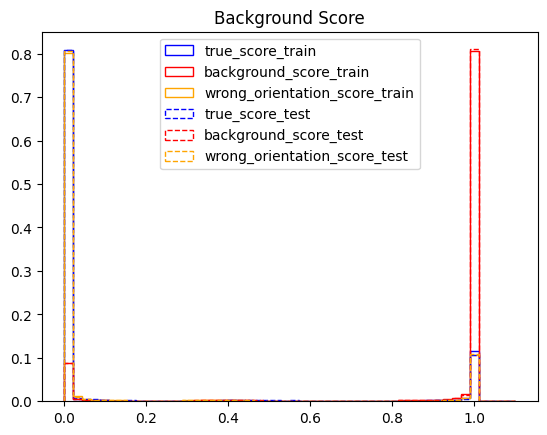

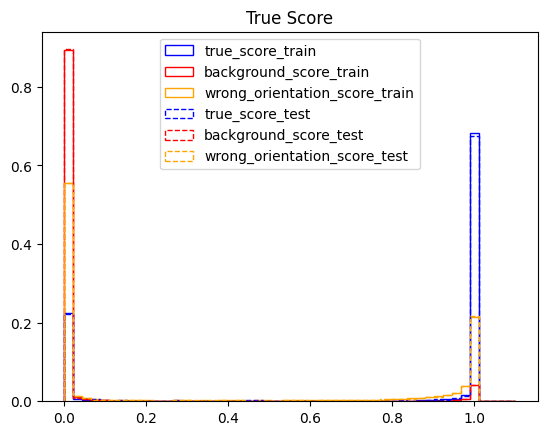

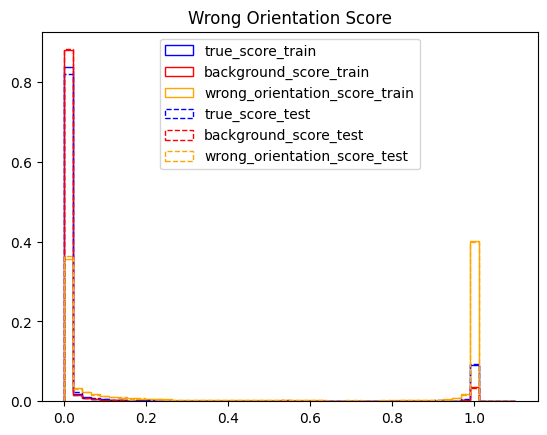

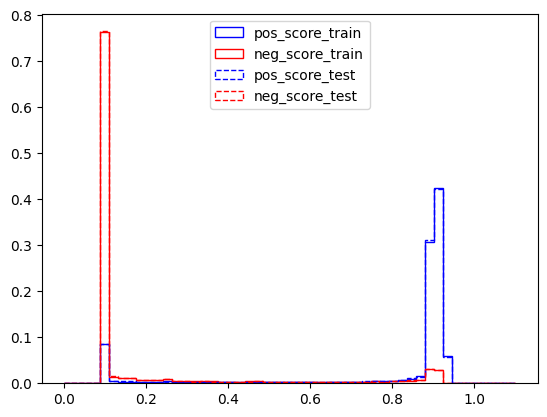

----------------------------------------
Epoch: 1
----------------------------------------
training_classification_loss: 0.54
----
optimal_threshold_train: 0.800000011920929
accuracy_train: 0.88%
positive_as_positive_fraction_train: 85.27%
positive_as_negative_fraction_train: 14.73%
negative_as_negative_fraction_train: 91.23%
negative_as_positive_fraction_train: 8.77%
----
testing_classification_loss: 0.53
----
optimal_threshold_test: 0.800000011920929
accuracy_test: 0.88%
positive_as_positive_fraction_test: 85.17%
positive_as_negative_fraction_test: 14.83%
negative_as_negative_fraction_test: 91.34%
negative_as_positive_fraction_test: 8.66%
----


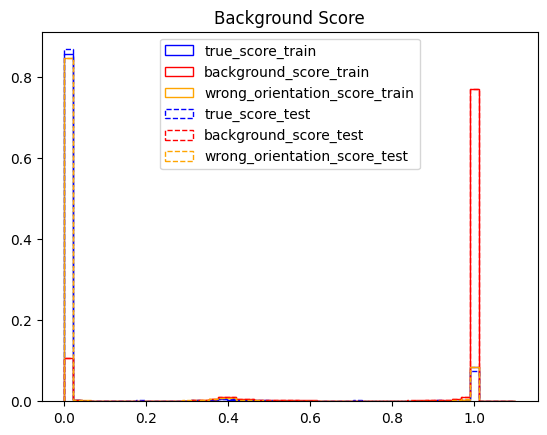

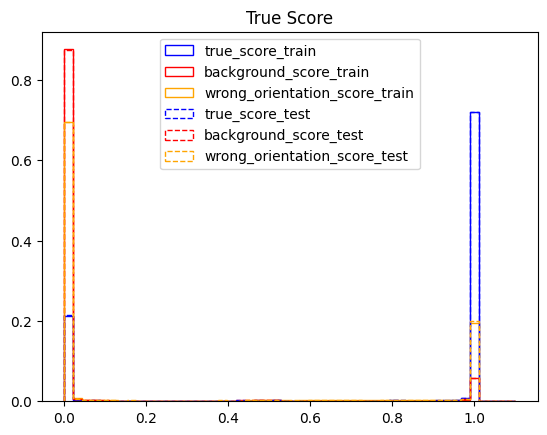

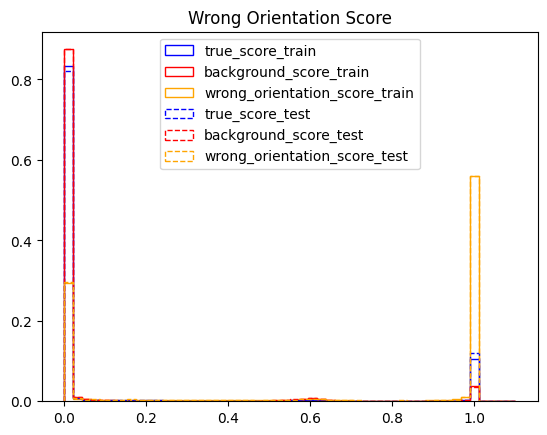

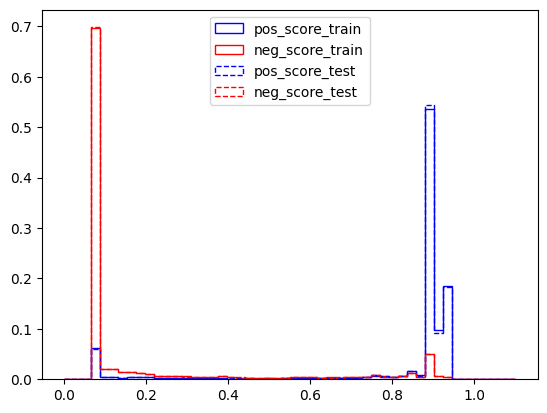

----------------------------------------
Epoch: 2
----------------------------------------
training_classification_loss: 0.52
----
optimal_threshold_train: 0.6499999761581421
accuracy_train: 0.89%
positive_as_positive_fraction_train: 85.46%
positive_as_negative_fraction_train: 14.54%
negative_as_negative_fraction_train: 91.61%
negative_as_positive_fraction_train: 8.39%
----
testing_classification_loss: 0.5
----
optimal_threshold_test: 0.699999988079071
accuracy_test: 0.89%
positive_as_positive_fraction_test: 84.71%
positive_as_negative_fraction_test: 15.29%
negative_as_negative_fraction_test: 92.39%
negative_as_positive_fraction_test: 7.61%
----


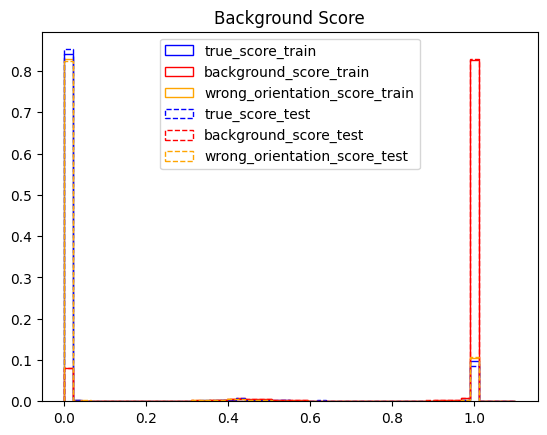

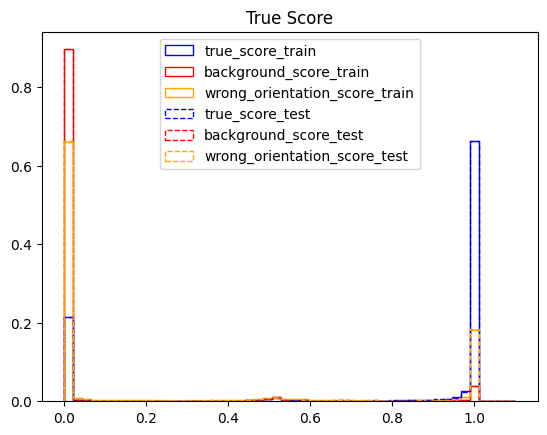

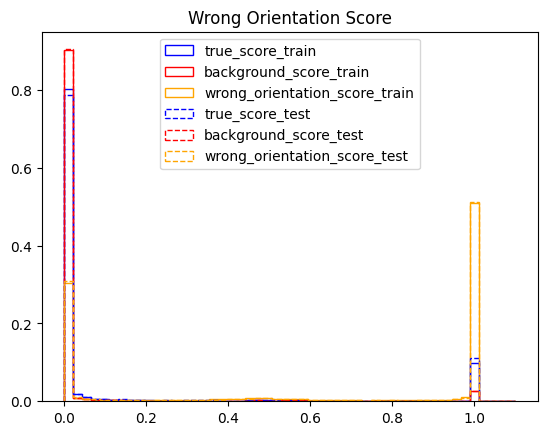

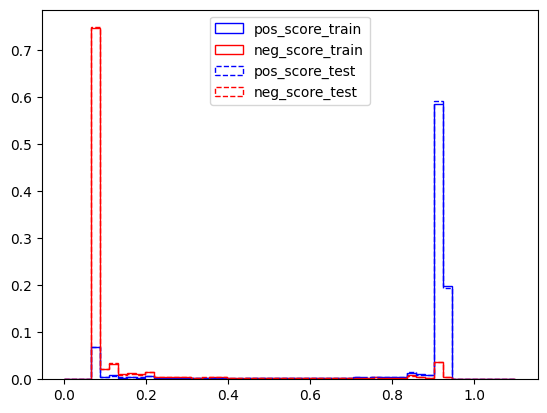

----------------------------------------
Epoch: 3
----------------------------------------
training_classification_loss: 0.53
----
optimal_threshold_train: 0.800000011920929
accuracy_train: 0.88%
positive_as_positive_fraction_train: 84.72%
positive_as_negative_fraction_train: 15.28%
negative_as_negative_fraction_train: 91.91%
negative_as_positive_fraction_train: 8.09%
----
testing_classification_loss: 0.51
----
optimal_threshold_test: 0.800000011920929
accuracy_test: 0.88%
positive_as_positive_fraction_test: 84.7%
positive_as_negative_fraction_test: 15.3%
negative_as_negative_fraction_test: 91.85%
negative_as_positive_fraction_test: 8.15%
----


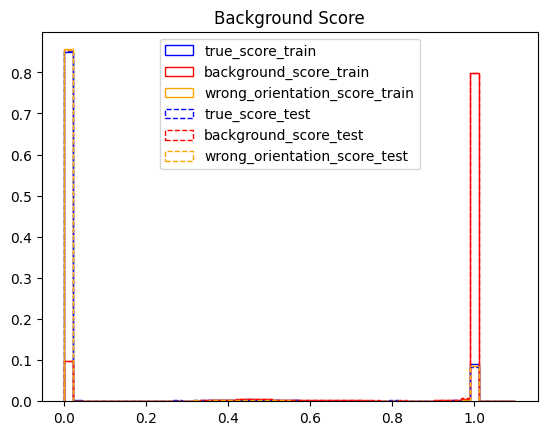

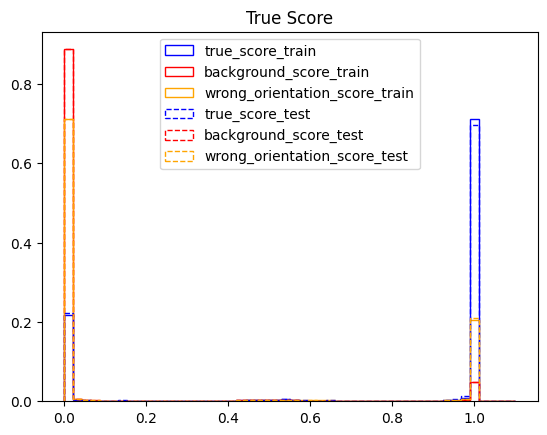

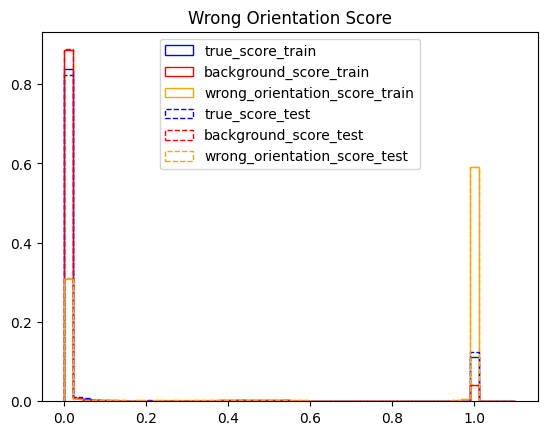

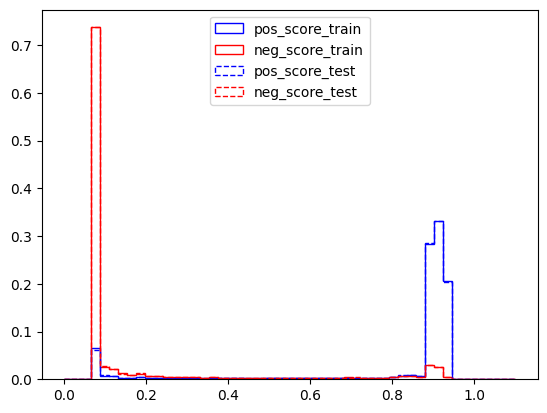

----------------------------------------
Epoch: 4
----------------------------------------
training_classification_loss: 0.52
----
optimal_threshold_train: 0.699999988079071
accuracy_train: 0.89%
positive_as_positive_fraction_train: 85.33%
positive_as_negative_fraction_train: 14.67%
negative_as_negative_fraction_train: 91.78%
negative_as_positive_fraction_train: 8.22%
----
testing_classification_loss: 0.5
----
optimal_threshold_test: 0.75
accuracy_test: 0.89%
positive_as_positive_fraction_test: 84.82%
positive_as_negative_fraction_test: 15.18%
negative_as_negative_fraction_test: 92.3%
negative_as_positive_fraction_test: 7.7%
----


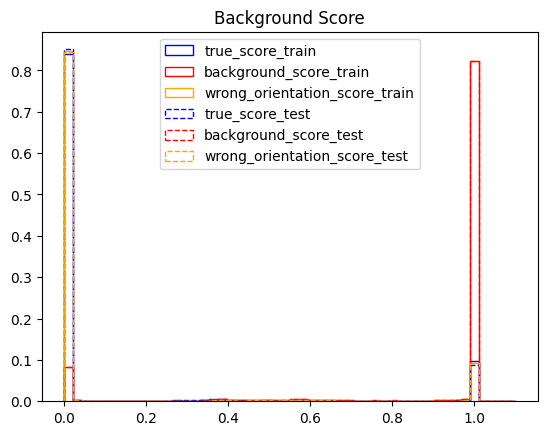

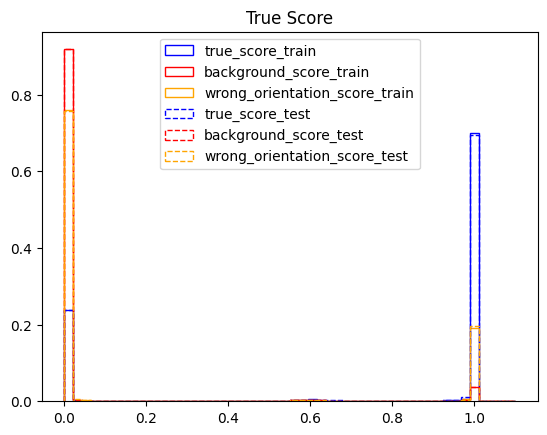

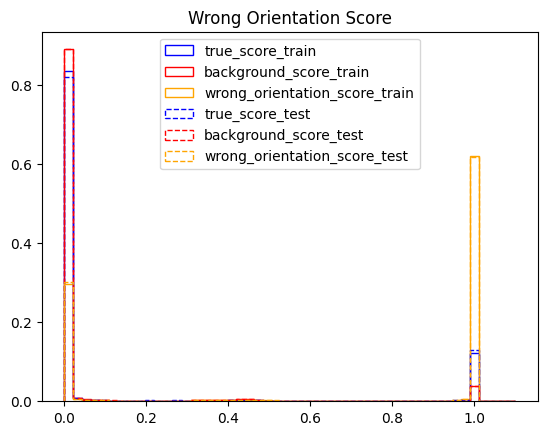

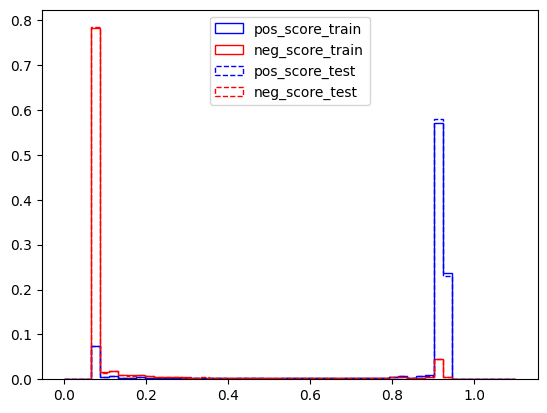

In [18]:
######################
# Training and testing
######################

# Optimiser
#optimiser = torch.optim.Adam(itertools.chain(model_0.parameters(), model_1.parameters(), classifier_model.parameters()), lr=LEARNING_RATE)
optimiser = torch.optim.Adam(itertools.chain(model_0.parameters(), classifier_model.parameters()), lr=LEARNING_RATE)
#loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='abs')

# Put here some metrics
training_epoch = []
training_loss_0 = []
training_loss_1 = []
training_loss_2 = []
training_loss_3 = []
training_classification_loss = []
training_accuracy = []
training_positive_as_positive_rate = []
training_positive_as_negative_rate = []
training_negative_as_negative_rate = []
training_negative_as_positive_rate = []

testing_epoch = []
testing_loss_0 = []
testing_loss_1 = []
testing_loss_2 = []
testing_loss_3 = []
testing_classification_loss = []
testing_accuracy = []
testing_positive_as_positive_rate = []
testing_positive_as_negative_rate = []
testing_negative_as_negative_rate = []
testing_negative_as_positive_rate = []

for epoch in range(N_EPOCHS):
    
    ######################
    # Training 
    ######################    
    model_0.train()
    #model_1.train()
    classifier_model.train()
    
    # Iterate in batches over the training dataset.                        
    for features_0, features_1, features_2, features_3, \
        target_0, target_1, target_2, target_3, target, new_gen in loader_train :  
        
        # Skip incomplete batches
        if (target.shape[0] != BATCH_SIZE) :
            continue        
            
        # Get predictions
        pred_0 = model_0(features_0)
        pred_1 = model_0(features_1)
        pred_2 = model_0(features_2)
        pred_3 = model_0(features_3)
        classifier_pred = classifier_model(torch.concatenate((pred_0, pred_1, pred_2, pred_3), axis=1))
        
        # Get loss
        target_0 = target_0.to(torch.long)
        target_1 = target_1.to(torch.long)
        target_2 = target_2.to(torch.long)
        target_3 = target_3.to(torch.long)
        classifier_target = target.to(torch.long).reshape(-1,1)
        loss_0 = loss_function_branch(pred_0, target_0, new_gen, classWeights_branch)        
        loss_1 = loss_function_branch(pred_1, target_1, new_gen, classWeights_branch)
        loss_2 = loss_function_branch(pred_2, target_2, new_gen, classWeights_branch) 
        loss_3 = loss_function_branch(pred_3, target_3, new_gen, classWeights_branch) 
        classifier_loss = loss_function_classifier(classifier_pred, classifier_target, new_gen, classWeights_classifier)
        total_loss = loss_0 + loss_1 + loss_2 + loss_3 + classifier_loss
        
        # Update model parameters
        optimiser.zero_grad()
        total_loss.backward()
        optimiser.step()
        
    ######################
    # Validation metrics 
    ######################
    with torch.no_grad():
        
        # Begin testing mode
        model_0.eval()
        classifier_model.eval()
        
        # Initialise metrics        
        total_batches_train = 0        
        total_loss_0_train = 0
        true_scores_0_train = []
        background_scores_0_train = []
        wrong_orientation_scores_0_train = []
        total_loss_1_train = 0
        true_scores_1_train = []
        background_scores_1_train = []
        wrong_orientation_scores_1_train = []        
        total_loss_2_train = 0
        true_scores_2_train = []
        background_scores_2_train = []
        wrong_orientation_scores_2_train = []        
        total_loss_3_train = 0
        true_scores_3_train = []
        background_scores_3_train = []
        wrong_orientation_scores_3_train = []        
        total_classification_loss_train = 0
        positive_scores_train = []
        negative_scores_train = []
        
        total_batches_test = 0        
        total_loss_0_test = 0
        true_scores_0_test = []
        background_scores_0_test = []
        wrong_orientation_scores_0_test = []            
        total_loss_1_test = 0
        true_scores_1_test = []
        background_scores_1_test = []
        wrong_orientation_scores_1_test = []        
        total_loss_2_test = 0
        true_scores_2_test = []
        background_scores_2_test = []
        wrong_orientation_scores_2_test = []        
        total_loss_3_test = 0
        true_scores_3_test = []
        background_scores_3_test = []
        wrong_orientation_scores_3_test = []                
        total_classification_loss_test = 0
        positive_scores_test = []
        negative_scores_test = []        
                
        # Iterate in batches over the training dataset.                        
        for features_0_train, features_1_train, features_2_train, features_3_train, \
            target_0_train, target_1_train, target_2_train, target_3_train, target_train, new_gen_train in loader_train :  

            # Skip incomplete batches
            if (target_train.shape[0] != BATCH_SIZE) :
                continue        

            # Get predictions
            pred_0_train = model_0(features_0_train)
            pred_1_train = model_0(features_1_train)
            pred_2_train = model_0(features_2_train)
            pred_3_train = model_0(features_3_train)
            classifier_pred_train = classifier_model(torch.concatenate((pred_0_train, pred_1_train, pred_2_train, pred_3_train), axis=1))

            # Get loss
            target_0_train = target_0_train.to(torch.long)
            target_1_train = target_1_train.to(torch.long)
            target_2_train = target_2_train.to(torch.long)
            target_3_train = target_3_train.to(torch.long)            
            classifier_target_train = target_train.to(torch.long).reshape(-1,1)
            loss_0_train = loss_function_branch(pred_0_train, target_0_train, new_gen_train, classWeights_branch)   
            loss_1_train = loss_function_branch(pred_1_train, target_1_train, new_gen_train, classWeights_branch)
            loss_2_train = loss_function_branch(pred_2_train, target_2_train, new_gen_train, classWeights_branch)
            loss_3_train = loss_function_branch(pred_3_train, target_3_train, new_gen_train, classWeights_branch)            
            classifier_loss_train = loss_function_classifier(classifier_pred_train, classifier_target_train, new_gen_train, classWeights_classifier)
            total_loss_train = loss_0_train + loss_1_train + loss_2_train + loss_3_train + classifier_loss_train
            
            # Add to our metrics
            total_batches_train += 1            
            total_loss_0_train += loss_0_train.item()  
            true_scores_0_train.extend(np.array(pred_0_train.tolist())[torch.column_stack((target_0_train == 1, target_0_train == 1, target_0_train == 1)).numpy()].reshape(-1, 3))
            background_scores_0_train.extend(np.array(pred_0_train.tolist())[torch.column_stack((target_0_train == 0, target_0_train == 0, target_0_train == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_0_train.extend(np.array(pred_0_train.tolist())[torch.column_stack((target_0_train == 2, target_0_train == 2, target_0_train == 2)).numpy()].reshape(-1, 3))
            total_loss_1_train += loss_1_train.item()  
            true_scores_1_train.extend(np.array(pred_1_train.tolist())[torch.column_stack((target_1_train == 1, target_1_train == 1, target_1_train == 1)).numpy()].reshape(-1, 3))
            background_scores_1_train.extend(np.array(pred_1_train.tolist())[torch.column_stack((target_1_train == 0, target_1_train == 0, target_1_train == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_1_train.extend(np.array(pred_1_train.tolist())[torch.column_stack((target_1_train == 2, target_1_train == 2, target_1_train == 2)).numpy()].reshape(-1, 3))            
            total_loss_2_train += loss_2_train.item()  
            true_scores_2_train.extend(np.array(pred_2_train.tolist())[torch.column_stack((target_2_train == 1, target_2_train == 1, target_2_train == 1)).numpy()].reshape(-1, 3))
            background_scores_2_train.extend(np.array(pred_2_train.tolist())[torch.column_stack((target_2_train == 0, target_2_train == 0, target_2_train == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_2_train.extend(np.array(pred_2_train.tolist())[torch.column_stack((target_2_train == 2, target_2_train == 2, target_2_train == 2)).numpy()].reshape(-1, 3))            
            total_loss_3_train += loss_3_train.item()  
            true_scores_3_train.extend(np.array(pred_3_train.tolist())[torch.column_stack((target_3_train == 1, target_3_train == 1, target_3_train == 1)).numpy()].reshape(-1, 3))
            background_scores_3_train.extend(np.array(pred_3_train.tolist())[torch.column_stack((target_3_train == 0, target_3_train == 0, target_3_train == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_3_train.extend(np.array(pred_3_train.tolist())[torch.column_stack((target_3_train == 2, target_3_train == 2, target_3_train == 2)).numpy()].reshape(-1, 3))              
            total_classification_loss_train += classifier_loss_train.item()
            positive_scores_train.extend(np.array(classifier_pred_train.tolist())[(classifier_target_train == 1).numpy()].reshape(-1))
            negative_scores_train.extend(np.array(classifier_pred_train.tolist())[(classifier_target_train == 0).numpy()].reshape(-1))
            
        training_epoch.append(epoch)            
            
        # Iterate in batches over the testing dataset.                        
        for features_0_test, features_1_test, features_2_test, features_3_test, \
            target_0_test, target_1_test, target_2_test, target_3_test, target_test, new_gen_test in loader_test :  

            # Skip incomplete batches
            if (target_test.shape[0] != BATCH_SIZE) :
                continue        

            # Get predictions
            pred_0_test = model_0(features_0_test)
            pred_1_test = model_0(features_1_test)
            pred_2_test = model_0(features_2_test)
            pred_3_test = model_0(features_3_test)            
            classifier_pred_test = classifier_model(torch.concatenate((pred_0_test, pred_1_test, pred_2_test, pred_3_test), axis=1))

            # Get loss
            target_0_test = target_0_test.to(torch.long)
            target_1_test = target_1_test.to(torch.long)
            target_2_test = target_2_test.to(torch.long)
            target_3_test = target_3_test.to(torch.long)            
            classifier_target_test = target_test.to(torch.long).reshape(-1,1)
            loss_0_test = loss_function_branch(pred_0_test, target_0_test, new_gen_test, classWeights_branch)   
            loss_1_test = loss_function_branch(pred_1_test, target_1_test, new_gen_test, classWeights_branch)
            loss_2_test = loss_function_branch(pred_2_test, target_2_test, new_gen_test, classWeights_branch)
            loss_3_test = loss_function_branch(pred_3_test, target_3_test, new_gen_test, classWeights_branch)            
            classifier_loss_test = loss_function_classifier(classifier_pred_test, classifier_target_test, new_gen_test, classWeights_classifier)
            total_loss_test = loss_0_test + loss_1_test + loss_2_test + loss_3_test + classifier_loss_test
            
            # Add to our metrics
            total_batches_test += 1          
            total_loss_0_test += loss_0_test.item()             
            true_scores_0_test.extend(np.array(pred_0_test.tolist())[torch.column_stack((target_0_test == 1, target_0_test == 1, target_0_test == 1)).numpy()].reshape(-1, 3))
            background_scores_0_test.extend(np.array(pred_0_test.tolist())[torch.column_stack((target_0_test == 0, target_0_test == 0, target_0_test == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_0_test.extend(np.array(pred_0_test.tolist())[torch.column_stack((target_0_test == 2, target_0_test == 2, target_0_test == 2)).numpy()].reshape(-1, 3))            
            total_loss_1_test += loss_1_test.item()             
            true_scores_1_test.extend(np.array(pred_1_test.tolist())[torch.column_stack((target_1_test == 1, target_1_test == 1, target_1_test == 1)).numpy()].reshape(-1, 3))
            background_scores_1_test.extend(np.array(pred_1_test.tolist())[torch.column_stack((target_1_test == 0, target_1_test == 0, target_1_test == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_1_test.extend(np.array(pred_1_test.tolist())[torch.column_stack((target_1_test == 2, target_1_test == 2, target_1_test == 2)).numpy()].reshape(-1, 3))            
            total_loss_2_test += loss_2_test.item()             
            true_scores_2_test.extend(np.array(pred_2_test.tolist())[torch.column_stack((target_2_test == 1, target_2_test == 1, target_2_test == 1)).numpy()].reshape(-1, 3))
            background_scores_2_test.extend(np.array(pred_2_test.tolist())[torch.column_stack((target_2_test == 0, target_2_test == 0, target_2_test == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_2_test.extend(np.array(pred_2_test.tolist())[torch.column_stack((target_2_test == 2, target_2_test == 2, target_2_test == 2)).numpy()].reshape(-1, 3))            
            total_loss_2_test += loss_2_test.item()             
            true_scores_2_test.extend(np.array(pred_2_test.tolist())[torch.column_stack((target_2_test == 1, target_2_test == 1, target_2_test == 1)).numpy()].reshape(-1, 3))
            background_scores_2_test.extend(np.array(pred_2_test.tolist())[torch.column_stack((target_2_test == 0, target_2_test == 0, target_2_test == 0)).numpy()].reshape(-1, 3))
            wrong_orientation_scores_2_test.extend(np.array(pred_2_test.tolist())[torch.column_stack((target_2_test == 2, target_2_test == 2, target_2_test == 2)).numpy()].reshape(-1, 3))                        
            total_classification_loss_test += classifier_loss_test.item()
            positive_scores_test.extend(np.array(classifier_pred_test.tolist())[(classifier_target_test == 1).numpy()].reshape(-1))
            negative_scores_test.extend(np.array(classifier_pred_test.tolist())[(classifier_target_test == 0).numpy()].reshape(-1))            
            
        testing_epoch.append(epoch)
    
    ##########################
    # Calc metrics for epoch 
    ##########################   
    # train
    optimal_threshold_train, maximum_accuracy_train = TrainingMetrics.calculate_accuracy(torch.tensor(positive_scores_train), torch.tensor(negative_scores_train)) 
    # test
    optimal_threshold_test, maximum_accuracy_test = TrainingMetrics.calculate_accuracy(torch.tensor(positive_scores_test), torch.tensor(negative_scores_test))

    # train
    positive_as_positive_train = np.count_nonzero(np.array(positive_scores_train) > optimal_threshold_train)
    positive_as_negative_train = np.count_nonzero(np.array(positive_scores_train) < optimal_threshold_train)
    negative_as_positive_train = np.count_nonzero(np.array(negative_scores_train) > optimal_threshold_train)
    negative_as_negative_train = np.count_nonzero(np.array(negative_scores_train) < optimal_threshold_train)
    # test
    positive_as_positive_test = np.count_nonzero(np.array(positive_scores_test) > optimal_threshold_test)
    positive_as_negative_test = np.count_nonzero(np.array(positive_scores_test) < optimal_threshold_test)
    negative_as_positive_test = np.count_nonzero(np.array(negative_scores_test) > optimal_threshold_test)
    negative_as_negative_test = np.count_nonzero(np.array(negative_scores_test) < optimal_threshold_test)
    
    # train
    positive_as_positive_fraction_train = float(positive_as_positive_train) / float(positive_as_positive_train + positive_as_negative_train)
    positive_as_negative_fraction_train = float(positive_as_negative_train) / float(positive_as_positive_train + positive_as_negative_train)
    negative_as_positive_fraction_train = float(negative_as_positive_train) / float(negative_as_positive_train + negative_as_negative_train)
    negative_as_negative_fraction_train = float(negative_as_negative_train) / float(negative_as_positive_train + negative_as_negative_train)
    # test
    positive_as_positive_fraction_test = float(positive_as_positive_test) / float(positive_as_positive_test + positive_as_negative_test)
    positive_as_negative_fraction_test = float(positive_as_negative_test) / float(positive_as_positive_test + positive_as_negative_test)
    negative_as_positive_fraction_test = float(negative_as_positive_test) / float(negative_as_positive_test + negative_as_negative_test)
    negative_as_negative_fraction_test = float(negative_as_negative_test) / float(negative_as_positive_test + negative_as_negative_test)
    
    # Add to our metrics
    training_loss_0.append(float(total_loss_0_train) / total_batches_train)
    training_loss_1.append(float(total_loss_1_train) / total_batches_train)
    training_classification_loss.append(float(total_classification_loss_train) / total_batches_train)
    training_accuracy.append(maximum_accuracy_train)
    training_positive_as_positive_rate.append(positive_as_positive_fraction_train)
    training_positive_as_negative_rate.append(positive_as_negative_fraction_train)
    training_negative_as_negative_rate.append(negative_as_negative_fraction_train)
    training_negative_as_positive_rate.append(negative_as_positive_fraction_train)
    
    testing_loss_0.append(float(total_loss_0_test) / total_batches_test)
    testing_loss_1.append(float(total_loss_1_test) / total_batches_test)
    testing_classification_loss.append(float(total_classification_loss_test) / total_batches_test)
    testing_positive_as_positive_rate.append(positive_as_positive_fraction_test)
    testing_positive_as_negative_rate.append(positive_as_negative_fraction_test)
    testing_negative_as_negative_rate.append(negative_as_negative_fraction_test)
    testing_negative_as_positive_rate.append(negative_as_positive_fraction_test)    
    
    # Do some prints
    print('----------------------------------------')
    print('Epoch:', epoch)
    print('----------------------------------------')
    print('training_classification_loss:', round(training_classification_loss[-1], 2))
    print('----')
    print('optimal_threshold_train:', optimal_threshold_train)
    print('accuracy_train:', str(round(maximum_accuracy_train.item(), 2)) +'%')
    print('positive_as_positive_fraction_train:', str(round(positive_as_positive_fraction_train * 100.0, 2)) + '%')
    print('positive_as_negative_fraction_train:', str(round(positive_as_negative_fraction_train * 100.0, 2)) + '%')
    print('negative_as_negative_fraction_train:', str(round(negative_as_negative_fraction_train * 100.0, 2)) + '%')
    print('negative_as_positive_fraction_train:', str(round(negative_as_positive_fraction_train * 100.0, 2)) + '%')
    print('----')
    print('testing_classification_loss:', round(testing_classification_loss[-1], 2))
    print('----')
    print('optimal_threshold_test:', optimal_threshold_test)
    print('accuracy_test:', str(round(maximum_accuracy_test.item(), 2)) +'%')
    print('positive_as_positive_fraction_test:', str(round(positive_as_positive_fraction_test * 100.0, 2)) + '%')
    print('positive_as_negative_fraction_test:', str(round(positive_as_negative_fraction_test * 100.0, 2)) + '%')
    print('negative_as_negative_fraction_test:', str(round(negative_as_negative_fraction_test * 100.0, 2)) + '%')
    print('negative_as_positive_fraction_test:', str(round(negative_as_positive_fraction_test * 100.0, 2)) + '%')
    print('----')
    TrainingMetrics.plot_scores_branch(background_scores_0_train, true_scores_0_train, wrong_orientation_scores_0_train, \
                                       background_scores_0_test, true_scores_0_test, wrong_orientation_scores_0_test, 0)
    TrainingMetrics.plot_scores_branch(background_scores_0_train, true_scores_0_train, wrong_orientation_scores_0_train, \
                                       background_scores_0_test, true_scores_0_test, wrong_orientation_scores_0_test, 1)
    TrainingMetrics.plot_scores_branch(background_scores_0_train, true_scores_0_train, wrong_orientation_scores_0_train, \
                                       background_scores_0_test, true_scores_0_test, wrong_orientation_scores_0_test, 2)   

#     TrainingMetrics.plot_scores_branch(background_scores_1_train, true_scores_1_train, wrong_orientation_scores_1_train, \
#                                        background_scores_1_test, true_scores_1_test, wrong_orientation_scores_1_test, 0)
#     TrainingMetrics.plot_scores_branch(background_scores_1_train, true_scores_1_train, wrong_orientation_scores_1_train, \
#                                        background_scores_1_test, true_scores_1_test, wrong_orientation_scores_1_test, 1)
#     TrainingMetrics.plot_scores_branch(background_scores_1_train, true_scores_1_train, wrong_orientation_scores_1_train, \
#                                        background_scores_1_test, true_scores_1_test, wrong_orientation_scores_1_test, 2)    
    TrainingMetrics.plot_scores_classifier(positive_scores_train, negative_scores_train, positive_scores_test, negative_scores_test)

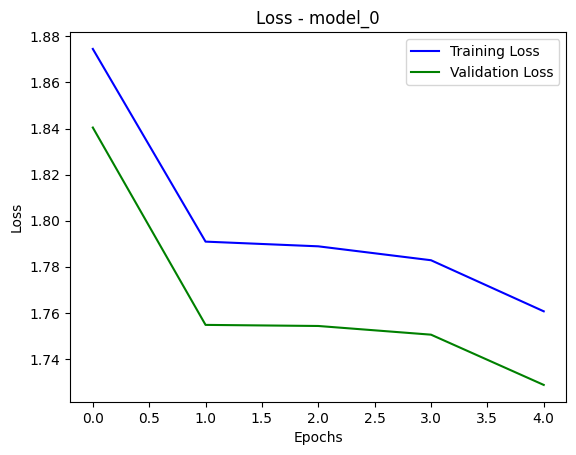

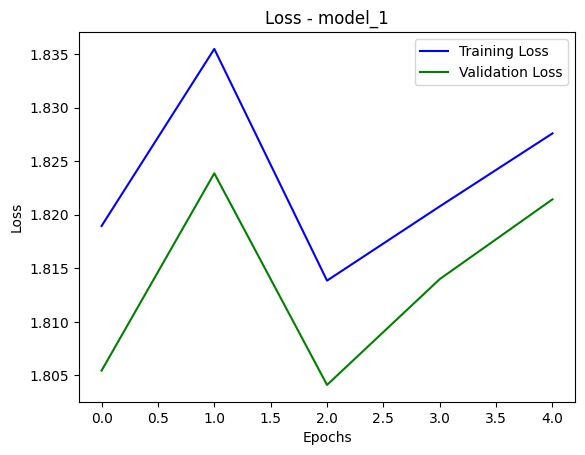

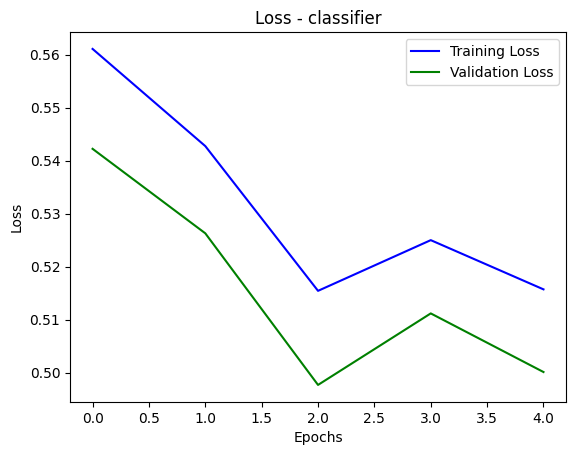

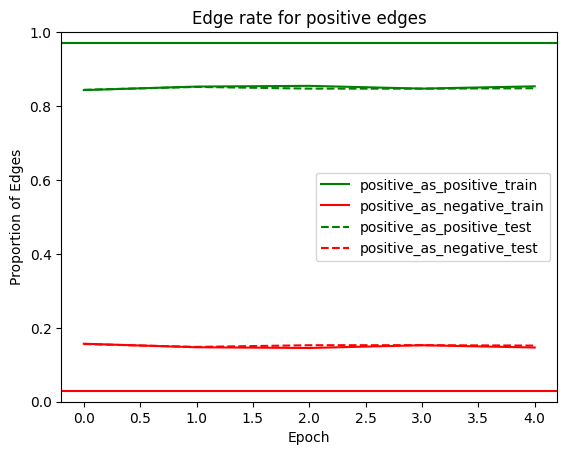

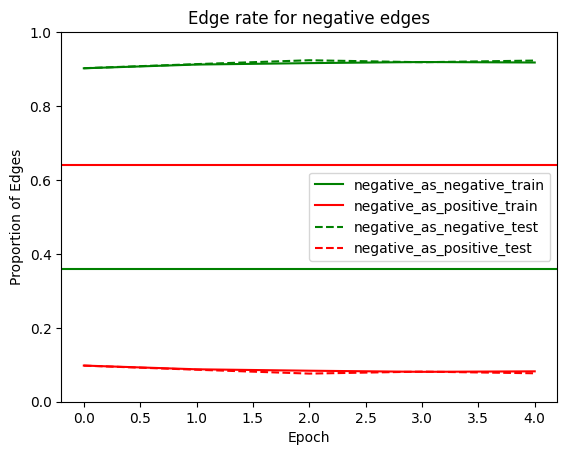

In [19]:
# Print metrics showing evolution   
TrainingMetrics.plot_loss_evolution(training_epoch, training_loss_0, testing_loss_0, 'Loss - model_0')
TrainingMetrics.plot_loss_evolution(training_epoch, training_loss_1, testing_loss_1, 'Loss - model_1')
TrainingMetrics.plot_loss_evolution(training_epoch, training_classification_loss, testing_classification_loss, 'Loss - classifier')
TrainingMetrics.plot_edge_rate(training_epoch, training_positive_as_positive_rate, training_positive_as_negative_rate, testing_positive_as_positive_rate, testing_positive_as_negative_rate, True)
TrainingMetrics.plot_edge_rate(testing_epoch, training_negative_as_negative_rate, training_negative_as_positive_rate, testing_negative_as_negative_rate, testing_negative_as_positive_rate, False)

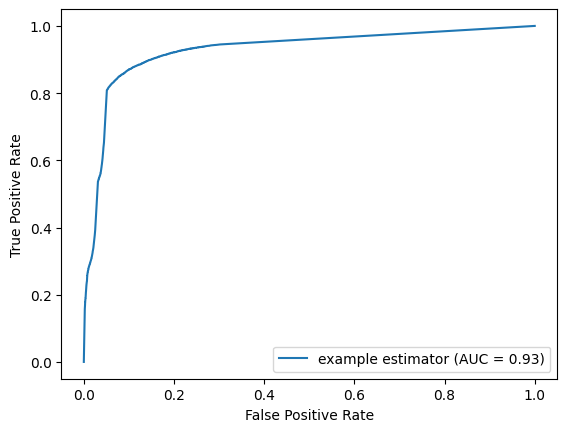

[[43138  4960]
 [ 1931 13137]]
[[42528  5570]
 [ 1796 13272]]


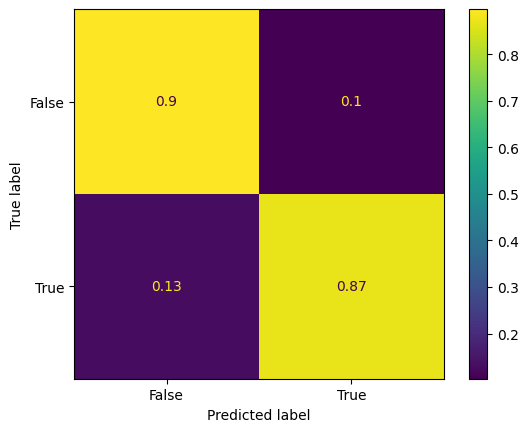

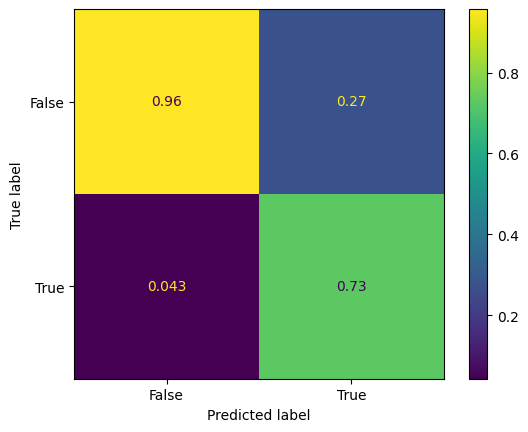

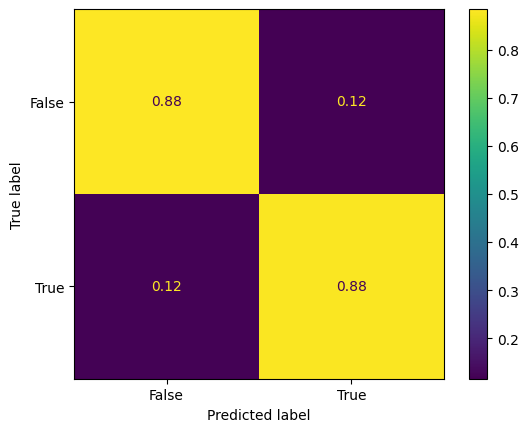

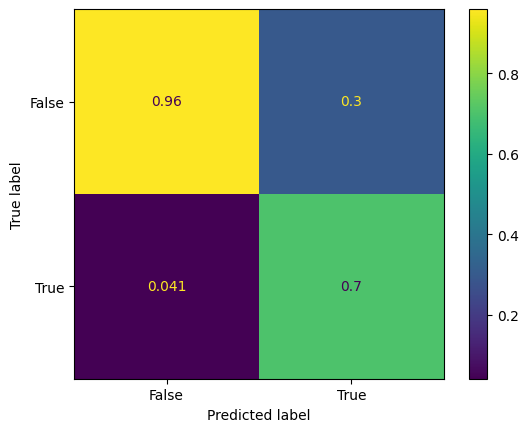

In [20]:
######################
# Confusion matrices!
######################
with torch.no_grad():

    # Begin testing mode
    model_0.eval()
    classifier_model.eval()
    # Get predictions
    pred_0_test = model_0(torch.tensor(input_0_test_temp, dtype=torch.float))
    pred_1_test = model_0(torch.tensor(input_1_test_temp, dtype=torch.float))
    pred_2_test = model_0(torch.tensor(input_2_test_temp, dtype=torch.float))
    pred_3_test = model_0(torch.tensor(input_3_test_temp, dtype=torch.float))    
    classifier_pred_test = classifier_model(torch.concatenate((pred_0_test, pred_1_test, pred_2_test, pred_3_test), axis=1)).reshape(-1)

    neg_scores_final_test = np.array(classifier_pred_test.tolist())[trueParentChildLink_test == 0].reshape(-1)
    pos_scores_final_test = np.array(classifier_pred_test.tolist())[trueParentChildLink_test == 1].reshape(-1)
    
    TrainingMetrics.plot_roc_curve(torch.tensor(pos_scores_final_test), torch.tensor(neg_scores_final_test))
    TrainingMetrics.draw_confusion_with_threshold(classifier_pred_test, trueParentChildLink_test, 0.5)
    TrainingMetrics.draw_confusion_with_threshold(classifier_pred_test, trueParentChildLink_test, 0.4)

In [21]:
######################
# Save the model
###################### 
sm_0 = torch.jit.script(model_0)
sm_0.save("/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/track_track_branch_model_torch")

sm = torch.jit.script(classifier_model)
sm.save("/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/track_track_classifier_model_torch")